Importing Modules

In [1]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
import time
from sklearn.svm import LinearSVC
from scipy.ndimage import minimum_position, maximum_position, center_of_mass
from scipy.ndimage.measurements import label

import tensorflow as tf
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Lambda, Dropout
from keras.layers.convolutional import Convolution2D, Convolution1D
from keras.layers.pooling import MaxPooling2D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Cropping2D, Cropping1D
from keras.models import load_model
import h5py
from keras import __version__ as keras_version

Using TensorFlow backend.


In [2]:
%matplotlib inline

In [83]:
import pickle

with open('svc3.pkl', 'rb') as f:
    svc = pickle.load(f)

with open('scaler3.pkl', 'rb') as f:
    X_scaler = pickle.load(f)    

In [85]:
# For running the neural networks
# Check if your system can load the neural network. If not, please upgrade/depreciate your keras version!
f = h5py.File('classifier2.h5', mode='r')

model_version = f.attrs.get('keras_version')
keras_version = str(keras_version).encode('utf8')

if model_version != keras_version:
    print('You are using Keras version ', keras_version,
          ', but the model was built using ', model_version)

model1 = load_model('classifier2.h5')
model2 = load_model('hog-classifier.h5')

In [101]:
# Function to create a grid of sliding windows
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], xy_overlap=(0.4, 0.4)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    # Compute the span of the region to be searched   
    width = x_start_stop[1] - x_start_stop[0]
    height = y_start_stop[1] - y_start_stop[0]
    
    size = int(img.shape[1] / 10)
    
    xy_windows = [(int(size/2), int(size/2)), (size,size), (int(size*1.5),int(size*1.5))]
    
    window_list = []
    
    for xy_window in xy_windows:
        xstep = int(xy_window[0] * xy_overlap[0])
        ystep = int(xy_window[1] * xy_overlap[1])

        xsize = xy_window[0]
        ysize = xy_window[1]    

        # Loop through finding x and y window positions
        y = y_start_stop[0]
        while y <= (y_start_stop[1] - ysize):
            x = x_start_stop[1]
            while x >= (x_start_stop[0] + xsize):
                position1 = (x, y)
                position2 = (x - xsize, y + ysize)
                window_list.append((position1, position2))
                x = x - xstep
                #xsize = xsize + 50
                #xstep = int(xsize * xy_overlap[0])
            y = y + ystep
    # Return the list of windows
    return window_list

def slide_window2(img, x_start_stop=[None, None], y_start_stop=[None, None], xy_overlap=(0.4, 0.4)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    # Compute the span of the region to be searched   
    width = x_start_stop[1] - x_start_stop[0]
    height = y_start_stop[1] - y_start_stop[0]
    
    size = int(img.shape[1] / 10)
    
    xy_windows = [(size,size), (int(size/2), int(size/2)), (int(size*1.5),int(size*1.5))]
    
    window_list = []
    
    for xy_window in xy_windows:
        xstep = int(xy_window[0] * xy_overlap[0])
        ystep = int(xy_window[1] * xy_overlap[1])

        xsize = xy_window[0]
        ysize = xy_window[1]    

        # Loop through finding x and y window positions
        y = y_start_stop[0]
        while y <= (y_start_stop[1] - ysize):
            x = x_start_stop[1]
            while x >= (x_start_stop[0] + xsize):
                position1 = (x, y)
                position2 = (x - xsize, y + ysize)
                window_list.append((position1, position2))
                x = x - xstep
                #xsize = xsize + 50
                #xstep = int(xsize * xy_overlap[0])
            y = y + ystep
    # Return the list of windows
    return window_list


def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)


# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Function to detect cars in sliding windows
def search_windows_new(img, windows, model1, model2):
    eq = cv2.equalizeHist(img)
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[1][0]:window[0][0]], (64, 64))
        test_img2 = cv2.resize(eq[window[0][1]:window[1][1], window[1][0]:window[0][0]], (64, 64))
        #test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        hog_feat = hog(test_img, orientations=12, pixels_per_cell=(8,8), cells_per_block=(2,2), transform_sqrt=True, visualise=False, feature_vector=False)
        
        y1 = np.expand_dims(test_img, axis=0)
        y2 = np.expand_dims(test_img2, axis=0)
        y3 = np.expand_dims(hog_feat, axis=0)

        prediction1 = round(float(model1.predict(y1)[0]))
        prediction2 = round(float(model1.predict(y2)[0]))
        prediction3 = round(float(model2.predict(y3)[0]))
        
        if (prediction1 == 1 | prediction2 == 1 | prediction3 == 1):
            on_windows.append(window)

    #8) Return windows for positive detections
    return on_windows


def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=False):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    # An array to store detection boxes
    detections = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                
                position = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
                
                detections.append(position)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return detections
    

In [35]:
import glob

vehicle_filenames = glob.glob('./training_data/vehicles/*/*.png')
nonvehicle_filenames = glob.glob('./training_data/non-vehicles/*/*.png')

vtrain = np.ones(len(vehicle_filenames))
ntrain = np.zeros(len(nonvehicle_filenames))
y = np.hstack((vtrain, ntrain))
filenames = np.hstack((vehicle_filenames, nonvehicle_filenames))

print (y.shape, filenames.shape)

(17760,) (17760,)


#### Let's visualize the training set. I've used YCrCb color space for training.

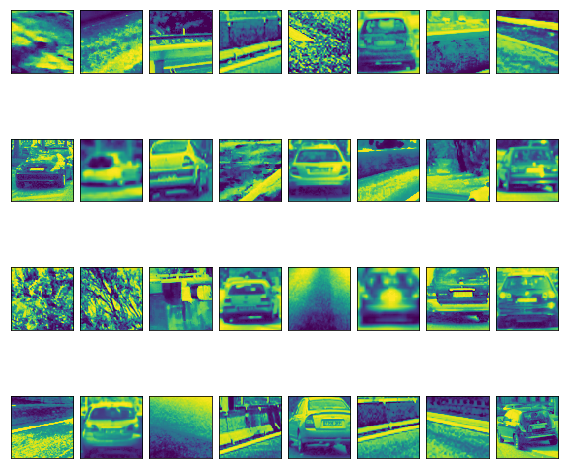

In [100]:
x = random.sample(range(1, len(filenames)), 32)
fig = plt.figure(figsize=(8,8))
axes = []
for i in range(0, len(x)):
    axis = fig.add_subplot(4,8,i+1)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    #axis.imshow(mpimg.imread(filenames[x[i]]))
    axis.imshow(cv2.equalizeHist(cv2.imread(filenames[x[i]], 0)))

plt.tight_layout(h_pad=0, w_pad=0)
plt.savefig('visualize.jpg')
plt.show()

## Training Model 1 (Linear SVC)
#### Uses spatial, color histogram and HOG features

In [ ]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

car_features = extract_features(vehicle_filenames, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(nonvehicle_filenames, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        


In [16]:
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')


Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7872
5.2 Seconds to train SVC...


In [17]:
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Test Accuracy of SVC =  0.9896


## Training Model 2 (Attempting Neural Networks)

In [7]:
# MODEL 2

model = Sequential()
    
model.add(Convolution1D(64, 3, input_shape=(64, 64)))
model.add(Activation('relu'))

model.add(Convolution1D(128, 3))
model.add(Activation('relu'))
model.add(MaxPooling1D(3))

model.add(Convolution1D(128, 3))
model.add(Activation('relu'))
model.add(MaxPooling1D(3))

model.add(Convolution1D(256, 3))
model.add(Activation('relu'))
model.add(MaxPooling1D(2))

model.add(Flatten())

model.add(Dense(128))
model.add(Dropout(0.25, seed=7))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25, seed=7))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [97]:
model.fit(X_train, y_train, batch_size=64, nb_epoch=10, validation_split=0.1, shuffle=True)
model.save('classifier2.h5')

Train on 12787 samples, validate on 1421 samples
Epoch 1/10
12787/12787 [==============================] - 7s - loss: 0.3749 - acc: 0.8278 - val_loss: 0.2269 - val_acc: 0.9127
Epoch 2/10
12787/12787 [==============================] - 6s - loss: 0.2168 - acc: 0.9170 - val_loss: 0.2228 - val_acc: 0.9156
Epoch 3/10
12787/12787 [==============================] - 6s - loss: 0.1771 - acc: 0.9306 - val_loss: 0.1762 - val_acc: 0.9360
Epoch 4/10
12787/12787 [==============================] - 6s - loss: 0.1425 - acc: 0.9458 - val_loss: 0.1454 - val_acc: 0.9451
Epoch 5/10
12787/12787 [==============================] - 6s - loss: 0.1147 - acc: 0.9594 - val_loss: 0.1463 - val_acc: 0.9437
Epoch 6/10
12787/12787 [==============================] - 6s - loss: 0.1067 - acc: 0.9604 - val_loss: 0.1124 - val_acc: 0.9564
Epoch 7/10
12787/12787 [==============================] - 6s - loss: 0.0891 - acc: 0.9684 - val_loss: 0.1396 - val_acc: 0.9493
Epoch 8/10
12787/12787 [==============================] - 6s -

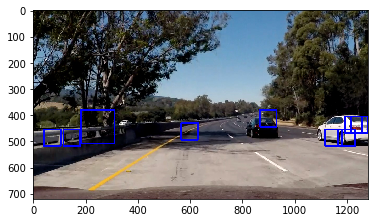

In [88]:
# Testing the models, without heatmaps

img = mpimg.imread('test_images/test5.jpg')
image = (cv2.imread('test_images/test5.jpg', 0))

windows = slide_window(image, y_start_stop=[380, 650])
detections = search_windows_new(image, windows, model1, model2)

new = draw_boxes(img, detections)
plt.imshow(new)
plt.savefig('neural_network.jpg')
plt.show()

#### HOG Features Visualization

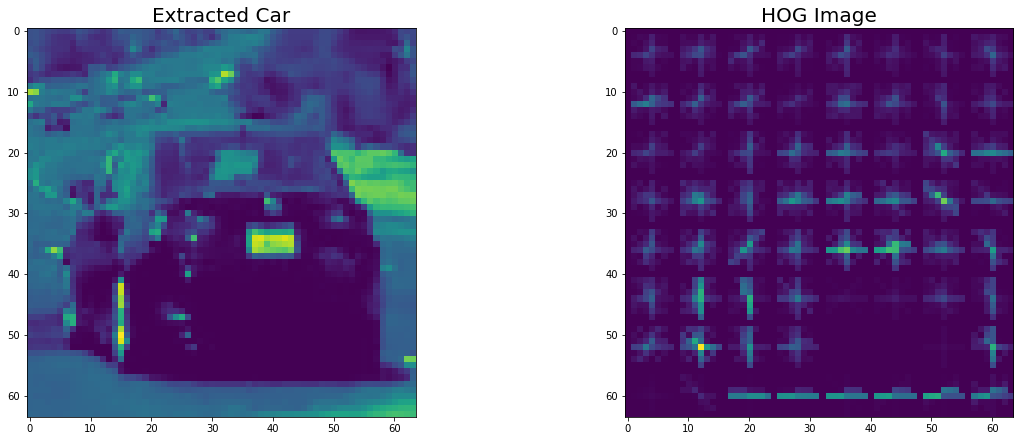

In [91]:
img = cv2.resize(image[380:500, 800:950], (64,64))
y = np.expand_dims(img, axis=0)
feat, hogm = hog(img, orientations=12, pixels_per_cell=(8,8), cells_per_block=(2,2), transform_sqrt=True, visualise=True, feature_vector=False)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Extracted Car', fontsize=20)
ax2.imshow(hogm) # Using undistort() function as defined above
ax2.set_title('HOG Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('./output_images/HOG_visualization.jpg')
plt.show()

## Training Model 3 (Using Just HOG features)

In [174]:
# Using a generator function, for efficiency
from sklearn.utils import shuffle

def generator(samples, labels, batch_size=64):
    num_samples = len(samples)
    samples, labels = shuffle(samples, labels)
    while 1: # Loop forever so the generator never terminates
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            batch_labels = labels[offset:offset+batch_size]
            
            images = []
            angles = []
            
            for i in range(len(batch_samples)):
                image = cv2.equalizeHist(cv2.imread(batch_samples[i], 0))
                angle = batch_labels[i]
                feat = hog(image, orientations=12, pixels_per_cell=(8,8), cells_per_block=(2,2), transform_sqrt=True, visualise=False, feature_vector=False)
                images.append(feat)
                angles.append(angle)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)

In [173]:
image = X_test[100]
feat = hog(image, orientations=12, pixels_per_cell=(8,8), cells_per_block=(2,2), transform_sqrt=True, visualise=False, feature_vector=False)
print (feat.shape)

(7, 7, 2, 2, 12)


In [160]:
import glob

vehicle_filenames = glob.glob('./vehicles/*/*.png')
nonvehicle_filenames = glob.glob('./non-vehicles/*/*.png')

vtrain = np.ones(len(vehicle_filenames))
ntrain = np.zeros(len(nonvehicle_filenames))
y = np.hstack((vtrain, ntrain))
filenames = np.hstack((vehicle_filenames, nonvehicle_filenames))

print (y.shape, filenames.shape)

(17760,) (17760,)


In [161]:
seed = 10
X_train2, X_test2, y_train2, y_test2 = train_test_split(filenames, y, test_size=0.2, random_state=10)

In [162]:
xtrain, xval, ytrain, yval = train_test_split(X_train2, y_train2, test_size=0.2, random_state=10)

In [175]:
train_gen = generator(xtrain, ytrain)
valid_gen = generator(xval, yval)

In [22]:
# MODEL 2

model = Sequential()
model.add(Flatten(input_shape=(7,7,2,2,12)))
model.add(Dense(256))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25, seed=7))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25, seed=7))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [176]:
model.fit_generator(train_gen, samples_per_epoch=len(xtrain), validation_data=valid_gen, nb_val_samples=len(xval), nb_epoch=10)
model.save('rog-classifier.h5')

Epoch 1/10
11366/11366 [==============================] - 33s - loss: 0.1859 - acc: 0.9264 - val_loss: 0.1077 - val_acc: 0.9595
Epoch 2/10
11366/11366 [==============================] - 30s - loss: 0.0819 - acc: 0.9693 - val_loss: 0.0793 - val_acc: 0.9701
Epoch 3/10
11366/11366 [==============================] - 31s - loss: 0.0449 - acc: 0.9861 - val_loss: 0.0967 - val_acc: 0.9662
Epoch 4/10
11366/11366 [==============================] - 31s - loss: 0.0402 - acc: 0.9857 - val_loss: 0.0627 - val_acc: 0.9785
Epoch 5/10
11366/11366 [==============================] - 31s - loss: 0.0262 - acc: 0.9908 - val_loss: 0.0727 - val_acc: 0.9757
Epoch 6/10
11366/11366 [==============================] - 30s - loss: 0.0196 - acc: 0.9935 - val_loss: 0.1025 - val_acc: 0.9719
Epoch 7/10
11366/11366 [==============================] - 30s - loss: 0.0167 - acc: 0.9945 - val_loss: 0.0474 - val_acc: 0.9859
Epoch 8/10
11366/11366 [==============================] - 30s - loss: 0.0111 - acc: 0.9960 - val_loss: 0

## How the heatmap pipeline works

[((1205, 405), (1141, 469)), ((930, 405), (866, 469)), ((1255, 430), (1191, 494)), ((880, 430), (816, 494)), ((330, 430), (266, 494)), ((1280, 380), (1152, 508)), ((1229, 380), (1101, 508)), ((1178, 380), (1050, 508)), ((923, 380), (795, 508))]


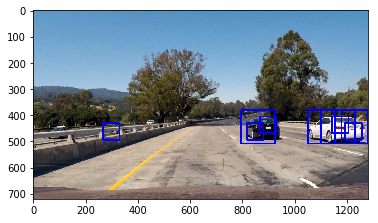

In [102]:
# Let's first detect cars in an image using one of our classifiers
img = cv2.imread('./test_images/test1.jpg', 0)
image = mpimg.imread('./test_images/test1.jpg')
windows = slide_window(img, y_start_stop=[380, 650])

detections = search_windows_new(img, windows, model1, model2)
print (detections)

plt.imshow(draw_boxes(image, detections))
plt.savefig('boxes.jpg')


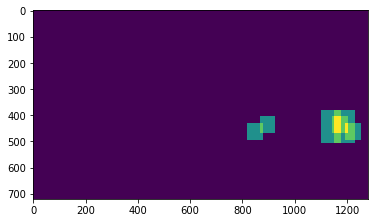

In [103]:
# How to build the heatmap
# Binary image of the same shape as input
blank = np.zeros_like(img)

#For each pixel in a detected box, increase its value by 1.
for window in (detections):
    blank[window[0][1]:window[1][1], window[1][0]:window[0][0]] += 1

# Now, pixes which fall into several overlapping boxes have a higher value than others
# The higher the value, the more the 'confidence' we have that it indicates a real vehicle
# By setting a threshold for false positives we can isolate these detected vehicles
false = (blank < 2)
blank[false] = 0

plt.imshow(blank)

(445.13231197771586, 1173.1713091922006) ((1109, 395), (1237, 495))
(449.74956498460716, 869.2918618658814) ((805, 399), (933, 499))


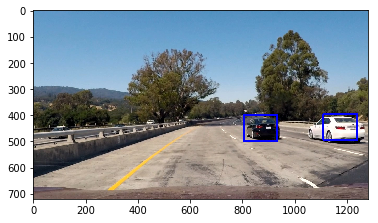

In [105]:
# Using skimage's label() function makes things super-convenient.
labels, n = label(blank)
boxes = []

for i in range(1, n+1):
    center = center_of_mass(blank, labels, i)
    minimax = int(center[0] - 50)
    minimay = int(center[1] - 64)
    maximax = int(center[0] + 50)
    maximay = int(center[1] + 64)
    pos = ((minimay, minimax), (maximay, maximax))
    boxes.append(pos)
    print (center, pos)
    boxes.append(pos)
    #feature = cv2.rectangle(feature, pos[0], pos[1], (0,0,255), 6)

plt.imshow(draw_boxes(image, boxes))
plt.savefig('after_heatmap.jpg')

Seems to work pretty well but is actually *extremely* inefficient.

## Final Image Processing Pipeline
### I have rejected the neural networks and will go only with the SVC classifier

In [94]:
# Image Processing Pipeline

previous_detections = []

def process_image(image):
    
    global previous_detections
    
    ystart = 380
    ystop = 650
    scale = 1
    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 12  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 32    # Number of histogram bins

    
    # Detecting vehicles using raw image data and HOG features
    vehicle_detections = find_cars(image, ystart, ystop, 
                                   scale, svc, X_scaler, 
                                   orient, pix_per_cell, cell_per_block, 
                                   spatial_size, hist_bins)
    
    # Updating previous frames' detections with new frame, and removing frames that are too old
    previous_detections.append(vehicle_detections)
    previous_detections = previous_detections[-10:]
    
    blank = np.zeros_like(image[:,:,0])

    for frame in previous_detections:
        for window in frame:
            blank[window[0][1]:window[1][1], window[0][0]:window[1][0]] += 1
    
    threshold = (blank < 3)
    blank[threshold] = 0

    # Label the different cars detected in image
    labels, n = label(blank)
    boxes = []

    # For each car, define its bounding boxes
    for i in range(1, n+1):
        center = center_of_mass(blank, labels, i)
        minimax = int(center[0] - 50)
        minimay = int(center[1] - 64)
        maximax = int(center[0] + 50)
        maximay = int(center[1] + 64)
        pos = ((minimay, minimax), (maximay, maximax))
        boxes.append(pos)

    new_blank = cv2.resize(blank, (266, 150))
    new_labels = np.dstack((new_blank*20, new_blank, new_blank))
    #return new_labels
    
    x_offset=y_offset=50
    l_img = draw_boxes(image, boxes)
    
    l_img[y_offset:y_offset+new_labels.shape[0], x_offset:x_offset+new_labels.shape[1]] = new_labels

    # Draw the boxes on original image
    return l_img

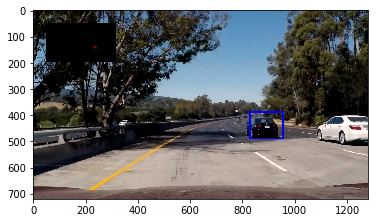

In [95]:
plt.imshow(process_image(mpimg.imread('./test_images/test5.jpg')))
plt.savefig('./output_images/final_result.jpg')

In [15]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy.video.VideoClip import VideoClip
from IPython.display import HTML

In [76]:
challenge_output = './attempts/test3.mp4'

windows = []
previous_detections = []

clip = VideoFileClip('test_video.mp4')
challenge_clip = clip.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video ./attempts/test3.mp4
[MoviePy] Writing video ./attempts/test3.mp4


 97%|█████████▋| 38/39 [00:46<00:01,  1.10s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./attempts/test3.mp4 

CPU times: user 43.2 s, sys: 1.83 s, total: 45 s
Wall time: 48.8 s


In [77]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [71]:
import pickle

with open('svc.pkl', 'wb') as f:
    pickle.dump(svc, f)

with open('scaler2.pkl', 'wb') as f:
    pickle.dump(X_scaler, f)

print ('Model saved')

Model saved
